# Benchmark Dynast's metabolic labeling quantification

This notebook will benchmark Dynast's runtime, memory usage and storage usage against those of the [scNT-seq pipeline](https://github.com/wulabupenn/scNT-seq). Note that several changes were necessary to the scNT-seq pipeline due to inherent bugs and outdated dependencies. The version used for this study can be found [here](https://github.com/Lioscro/scNT-seq).

In [717]:
import glob
import os
import re
import time

import anndata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.patches import Patch

plt.style.use('../figures.mplstyle')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Load the data

Load the runtime and memory usage from those recorded using `time`. Storage is calculated by adding the sizes of all the files (exclusing the `time` output).

In [508]:
with open('data/accessions.txt', 'r') as f:
    accessions = [line.strip() for line in f]
control_accession = accessions[0]
sample_accessions = accessions[1:]

def time_to_seconds(t):
    seconds = 0
    for i, value in enumerate(t.split(':')[::-1]):
        seconds += float(value) * (60 ** i)
    return seconds

def parse_time(out):
    groups = re.search(
        'Elapsed \(wall clock\) time \(h:mm:ss or m:ss\): (?P<runtime>[0-9:\.]+)'
        '.*?'
        'Maximum resident set size \(kbytes\): (?P<memory>[0-9]+)',
        out, re.DOTALL
    ).groupdict()
    return time_to_seconds(groups['runtime']), int(groups['memory']) * 1024

def read_results(out_dir, pipeline):
    print(out_dir, end='...')
    
    try:
        # NOTE: step can contain suffixes of the form _1, _2, ...
        step = os.path.basename(out_dir)
        search = re.search('_[0-9]+', step)
        if search:
            step = step[:search.start()]

        time_path = f'{out_dir}/time.txt'

        with open(time_path, 'r') as f:
            runtime, memory = parse_time(f.read())

        # Find path, exclusing time.txt
        storage = 0
        for dirpath, dirnames, filenames in os.walk(out_dir):
            if '.ipynb_checkpoints' in dirpath:
                continue
            for filename in filenames:
                if filename == 'time.txt':
                    continue
                path = os.path.join(dirpath, filename)
                storage += os.path.getsize(path)
                
        print('OK')
        return {
            'pipeline': pipeline,
            'accession': accession,
            'step': step,
            'runtime': runtime,
            'memory': memory,
            'storage': storage
        }
    except Exception as e:
        print(e)

# runtime in seconds
# memory in bytes
# storage in bytes
results = pd.DataFrame(columns=['pipeline', 'accession', 'step', 'runtime', 'memory', 'storage'])

# Dynast
for accession in accessions:
    for out_dir in sorted(glob.glob(f'dynast/{accession}/*')):
        res = read_results(out_dir, 'dynast')
        if res:
            results.loc[len(results)] = res

# scNT-seq pipeline
for accession in accessions:
    for out_dir in sorted(glob.glob(f'scNT/{accession}/*')):
        # Don't consider anndata conversions for scNT.
        if out_dir.endswith('adata'):
            continue
        
        res = read_results(out_dir, 'scNT')
        if res:
            results.loc[len(results)] = res

dynast/SRR12225122/align...OK
dynast/SRR12225122/consensus...OK
dynast/SRR12225122/consensus_filter...OK
dynast/SRR12225122/count...OK
dynast/SRR12225122/count_filter...OK
dynast/SRR11683967/align...OK
dynast/SRR11683967/consensus...OK
dynast/SRR11683967/consensus_filter...OK
dynast/SRR11683967/count...OK
dynast/SRR11683967/count_filter...OK
dynast/SRR11683968/align...OK
dynast/SRR11683968/consensus...OK
dynast/SRR11683968/consensus_filter...OK
dynast/SRR11683968/count...OK
dynast/SRR11683968/count_filter...OK
dynast/SRR11683969/align...OK
dynast/SRR11683969/consensus...OK
dynast/SRR11683969/consensus_filter...OK
dynast/SRR11683969/count...OK
dynast/SRR11683969/count_filter...OK
dynast/SRR11683970/align...OK
dynast/SRR11683970/consensus...OK
dynast/SRR11683970/consensus_filter...OK
dynast/SRR11683970/count...OK
dynast/SRR11683970/count_filter...OK
dynast/SRR11683971/align...OK
dynast/SRR11683971/consensus...OK
dynast/SRR11683971/consensus_filter...OK
dynast/SRR11683971/count...OK
dynas

In [783]:
accession_names = {
    'SRR12225122': 'Control',
    'SRR11683967': '0min',
    'SRR11683968': '15min',
    'SRR11683969': '30min',
    'SRR11683970': '60min',
    'SRR11683971': '120min'
}

## Comparisons

Compare the two pipelines.

### Runtime

Compare the runtimes for each step and accession.

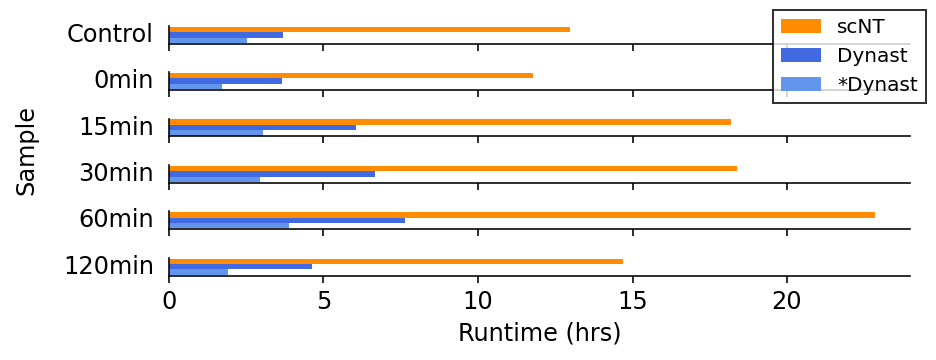

In [788]:
def plot_stacked_runtimes(results, label, i, order, width, ax, **kwargs):
    results = results[results['step'].isin(order)].copy()
    results['step'] = results['step'].astype(
        pd.CategoricalDtype(categories=order, ordered=True)
    )
    results['runtime'] = results['runtime'] / 3600
    
    min_runtime = 0
    max_runtime = 0
    
    height = 0
    for step, part in results.groupby('step'):
        min_runtime += part['runtime'].min()
        max_runtime += part['runtime'].max()
        
        mean = np.mean(part['runtime'])
        if step == order[-1]:
            err_low = (height + mean) - min_runtime
            err_high = max_runtime - (height + mean)
            ax.barh([label], [mean], width, xerr=[[err_low],[err_high]], left=[height], label=label, **kwargs)
        else:
            ax.barh([label], [mean], width, left=[height], label=label, **kwargs)
        
        # jitter = (np.random.random(part.shape[0]) * width) / 4
        # ax.scatter(part['runtime'] + height, jitter + i, zorder=10, color='gray', alpha=0.8, s=5)
        height += mean

fig, axes = plt.subplots(figsize=(6.5, len(accessions) * 0.42), nrows=len(accessions), sharex=True, tight_layout=True)

for ax, accession in zip(axes, accessions):
    accession_results = results[results['accession'] == accession]
    dynast_results = accession_results[(accession_results['pipeline'] == 'dynast')]
    scNT_results = accession_results[(accession_results['pipeline'] == 'scNT')]
    
    scNT_steps = ['Step1', 'Step2']
    if accession != control_accession:
        scNT_steps.extend(['Step3', 'Step4'])
    
    plot_stacked_runtimes(
        scNT_results, 'scNT', 0, scNT_steps, 1, ax,
        color='darkorange'
    )
    plot_stacked_runtimes(
        dynast_results, 'Dynast', 1, ['align', 'consensus', 'count'], 1, ax,
        color='royalblue'
    )
    plot_stacked_runtimes(
        dynast_results, 'Dynast (filtered)', 2, ['align', 'consensus_filter', 'count_filter'], 1, ax,
        color='cornflowerblue'
    )
    
    ylabel = accession_names[accession]
    ax.set_ylabel(ylabel, rotation=0, ha='right', va='center')
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.invert_yaxis()
axes[-1].set_xlabel('Runtime (hrs)')
# axes[0].legend()
fig.legend(handles=[
    Patch(facecolor='darkorange', label='scNT'),
    Patch(facecolor='royalblue', label='Dynast'),
    Patch(facecolor='cornflowerblue', label='*Dynast')
])
fig.supylabel('Sample', y=0.6)
fig.savefig('figures/scNT_runtime.png', bbox_inches='tight', dpi=300)

In [754]:
scNT_runtimes = results[results['pipeline'] == 'scNT'].groupby('accession')['runtime'].sum()
dynast_runtimes = results[
    (results['pipeline'] == 'dynast') & (~results['step'].str.endswith('_filter'))
].groupby('accession')['runtime'].sum()
dynast_filter_runtimes = results[
    (results['pipeline'] == 'dynast') & ((results['step'].str.endswith('_filter')) | (results['step'] == 'align'))
].groupby('accession')['runtime'].sum()

In [763]:
# Percent speedup
speedup = (scNT_runtimes - dynast_runtimes) / scNT_runtimes * 100
print(speedup)
print(f'Average speedup: {speedup.mean()}')

accession
SRR11683967    68.923878
SRR11683968    66.668688
SRR11683969    63.721642
SRR11683970    66.550884
SRR11683971    68.512718
SRR12225122    71.439288
Name: runtime, dtype: float64
Average speedup: 67.63618308662795


In [764]:
# Percent speedup (filter
speedup = (scNT_runtimes - dynast_filter_runtimes) / scNT_runtimes * 100
print(speedup)
print(f'Average speedup: {speedup.mean()}')

accession
SRR11683967    85.514829
SRR11683968    83.254728
SRR11683969    83.955338
SRR11683970    83.033394
SRR11683971    86.992753
SRR12225122    80.548923
Name: runtime, dtype: float64
Average speedup: 83.88332735020222


### Memory

Compare the maximum memory usage for each step and accession.

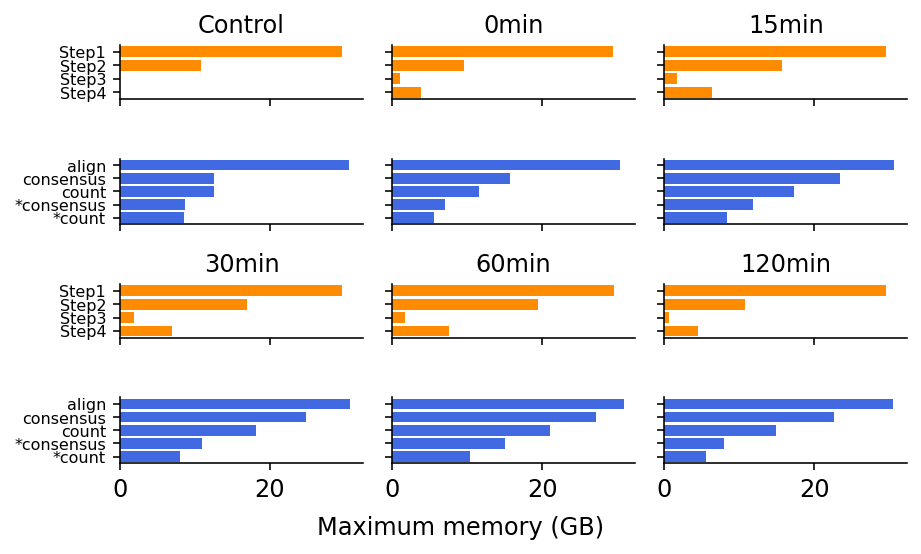

In [789]:
def plot_pipeline_step_memory(results, order, ax, **kwargs):
    results = results.copy()
    results['step'] = results['step'].astype(
        pd.CategoricalDtype(categories=order, ordered=True)
    )
    results['memory'] = results['memory'] / (1024 ** 3)
    sns.barplot(data=results, y='step', x='memory', ax=ax, saturation=1, **kwargs)
    
fig, axes = plt.subplots(figsize=(6.5, 4), ncols=3, nrows=4, sharex=True, gridspec_kw={'height_ratios': [4.1, 5, 4.1, 5]}, tight_layout=True)
for i, accession in enumerate(accessions):
    accession_results = results[results['accession'] == accession]
    dynast_results = accession_results[(accession_results['pipeline'] == 'dynast')]
    scNT_results = accession_results[(accession_results['pipeline'] == 'scNT')]
    
    row = i // 3
    col = i - (row * 3)
    scNT_ax = axes[row * 2, col]
    dynast_ax = axes[row * 2 + 1, col]
    
    plot_pipeline_step_memory(
        scNT_results, ['Step1', 'Step2', 'Step3', 'Step4'], ax=scNT_ax, color='darkorange'
    )
    plot_pipeline_step_memory(
        dynast_results,
        ['align', 'consensus', 'count', 'consensus_filter', 'count_filter'],
         ax=dynast_ax, color='royalblue'
    )
    scNT_ax.set_xlabel(None)
    scNT_ax.set_ylabel(None)
    # scNT_ax.set_yticks([])
    scNT_ax.set_yticklabels([])
    dynast_ax.set_xlabel(None)
    dynast_ax.set_ylabel(None)
    # dynast_ax.set_yticks([])
    dynast_ax.set_yticklabels([])
    
    scNT_ax.set_title(accession_names[accession])

for i, ax in enumerate(axes[:,0]):
    if i % 2 == 0:
        labels = ['Step1', 'Step2', 'Step3', 'Step4']
    else:
        labels = ['align', 'consensus', 'count', '*consensus', '*count']
    ax.set_yticks(np.arange(len(labels)))
    ax.set_yticklabels(labels, fontsize=8)

fig.supxlabel('Maximum memory (GB)', y=0.05)

fig.savefig('figures/scNT_memory.png', bbox_inches='tight', dpi=300)

### Storage

Compare the size of the output for each step and accession.

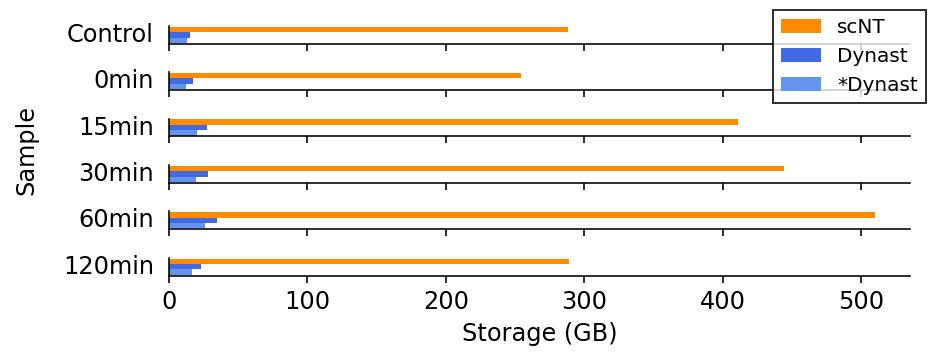

In [790]:
def plot_stacked_storage(results, label, i, order, width, ax, **kwargs):
    results = results[results['step'].isin(order)].copy()
    results['step'] = results['step'].astype(
        pd.CategoricalDtype(categories=order, ordered=True)
    )
    results['storage'] = results['storage'] / (1024 ** 3)
    
    height = 0
    for step, part in results.groupby('step'):
        mean = np.mean(part['storage'])
        ax.barh([label], [mean], width, left=[height], label=label, **kwargs)
        height += mean

fig, axes = plt.subplots(figsize=(6.5, len(accessions) * 0.42), nrows=len(accessions), sharex=True, tight_layout=True)

for ax, accession in zip(axes, accessions):
    accession_results = results[results['accession'] == accession]
    dynast_results = accession_results[(accession_results['pipeline'] == 'dynast')]
    scNT_results = accession_results[(accession_results['pipeline'] == 'scNT')]
    
    scNT_steps = ['Step1', 'Step2']
    if accession != control_accession:
        scNT_steps.extend(['Step3', 'Step4'])
    
    plot_stacked_storage(
        scNT_results, 'scNT', 0, scNT_steps, 1, ax,
        color='darkorange'
    )
    plot_stacked_storage(
        dynast_results, 'Dynast', 1, ['align', 'consensus', 'count'], 1, ax,
        color='royalblue'
    )
    plot_stacked_storage(
        dynast_results, 'Dynast (filtered)', 2, ['align', 'consensus_filter', 'count_filter'], 1, ax,
        color='cornflowerblue'
    )
    
    ylabel = accession_names[accession]
    ax.set_ylabel(ylabel, rotation=0, ha='right', va='center')
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.invert_yaxis()
axes[-1].set_xlabel('Storage (GB)')
# axes[0].legend()
fig.legend(handles=[
    Patch(facecolor='darkorange', label='scNT'),
    Patch(facecolor='royalblue', label='Dynast'),
    Patch(facecolor='cornflowerblue', label='*Dynast')
])
fig.supylabel('Sample', y=0.6)

fig.savefig('figures/scNT_storage.png', bbox_inches='tight', dpi=300)

In [771]:
scNT_storage = results[results['pipeline'] == 'scNT'].groupby('accession')['storage'].sum()
dynast_storage = results[
    (results['pipeline'] == 'dynast') & (~results['step'].str.endswith('_filter'))
].groupby('accession')['storage'].sum()
dynast_filter_storage = results[
    (results['pipeline'] == 'dynast') & ((results['step'].str.endswith('_filter')) | (results['step'] == 'align'))
].groupby('accession')['storage'].sum()

In [772]:
# Percent saved
storage = (scNT_storage - dynast_storage) / scNT_storage * 100
print(storage)
print(f'Average space improvement: {storage.mean()}')

accession
SRR11683967    93.209408
SRR11683968    93.317690
SRR11683969    93.655140
SRR11683970    93.234820
SRR11683971    91.942556
SRR12225122    94.671968
Name: storage, dtype: float64
Average space improvement: 93.3385969921186


In [773]:
# Percent saved (filter)
storage = (scNT_storage - dynast_filter_storage) / scNT_storage * 100
print(storage)
print(f'Average space improvement: {storage.mean()}')

accession
SRR11683967    95.127242
SRR11683968    95.057447
SRR11683969    95.520749
SRR11683970    94.894665
SRR11683971    94.340874
SRR12225122    95.420638
Name: storage, dtype: float64
Average space improvement: 95.06026895667553
